In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import math

import numpy as np
import datetime
from IPython.display import display
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")

from garmindb import GarminConnectConfigManager
from garmindb.garmindb import GarminSummaryDb, DaysSummary, MonitoringDb, MonitoringHeartRate, Sleep, GarminDb
from garmindb.summarydb import DaysSummary, SummaryDb

from jupyter_funcs import format_number
from graphs import Graph

In [2]:
def minsFromTime(t):
    return float(t.hour * 3600 + t.minute * 60 + t.second) / 60.0

In [3]:
# start date
start_ts = datetime.datetime.combine(datetime.date(year=2025, month=1, day=1), datetime.datetime.min.time())
# end date (today)
end_ts = datetime.datetime.combine(datetime.date.today(), datetime.datetime.max.time())

gc_config = GarminConnectConfigManager()
db_params = gc_config.get_db_params()

garmin_db = GarminDb(db_params)
sum_db = SummaryDb(db_params, False)
data = DaysSummary.get_for_period(sum_db, start_ts, end_ts, DaysSummary)
sleep = Sleep.get_for_period(garmin_db, start_ts, end_ts)

time = [entry.day for entry in data]

In [4]:
# If curious what data exists then list it with:
# list(reversed(dir(a))) 

In [5]:
stress_avg = [entry.stress_avg for entry in data]
bb_max = [entry.bb_max for entry in data]
bb_min = [entry.bb_min for entry in data]
rem_sleep_max = [minsFromTime(entry.rem_sleep_avg) for entry in data]
sleep_avg = [minsFromTime(entry.sleep_avg) / 60 for entry in data]
deep_sleep = [minsFromTime(sleep_event.deep_sleep) for sleep_event in sleep]
dm_df = pd.DataFrame([time, stress_avg, bb_max, bb_min, rem_sleep_max,deep_sleep, sleep_avg]).T
dm_df.columns = ["Date", "stress_avg", "bb_max", "bb_min", "rem_sleep_max", "deep_sleep", "sleep_avg"]
# remove the last record 'cause it's noisy sometimes
dm_df.drop(dm_df.tail(1).index,inplace=True) 
dm_df



,Date,stress_avg,bb_max,bb_min,rem_sleep_max,deep_sleep,sleep_avg
0,2025-01-02,24,66,30,44.0,119.0,7.148333
1,2025-01-03,23,86,33,129.0,108.0,8.572778
2,2025-01-04,24,86,29,76.0,113.0,8.883333
3,2025-01-05,20,96,40,73.0,93.0,8.3
4,2025-01-06,20,100,37,94.0,55.0,8.178889
...,...,...,...,...,...,...,...
87,2025-03-30,22,81,23,106.0,69.0,8.2
88,2025-03-31,19,96,35,59.0,98.0,8.411667
89,2025-04-01,22,99,35,65.0,130.0,7.773889
90,2025-04-02,24,98,30,68.0,72.0,7.183333


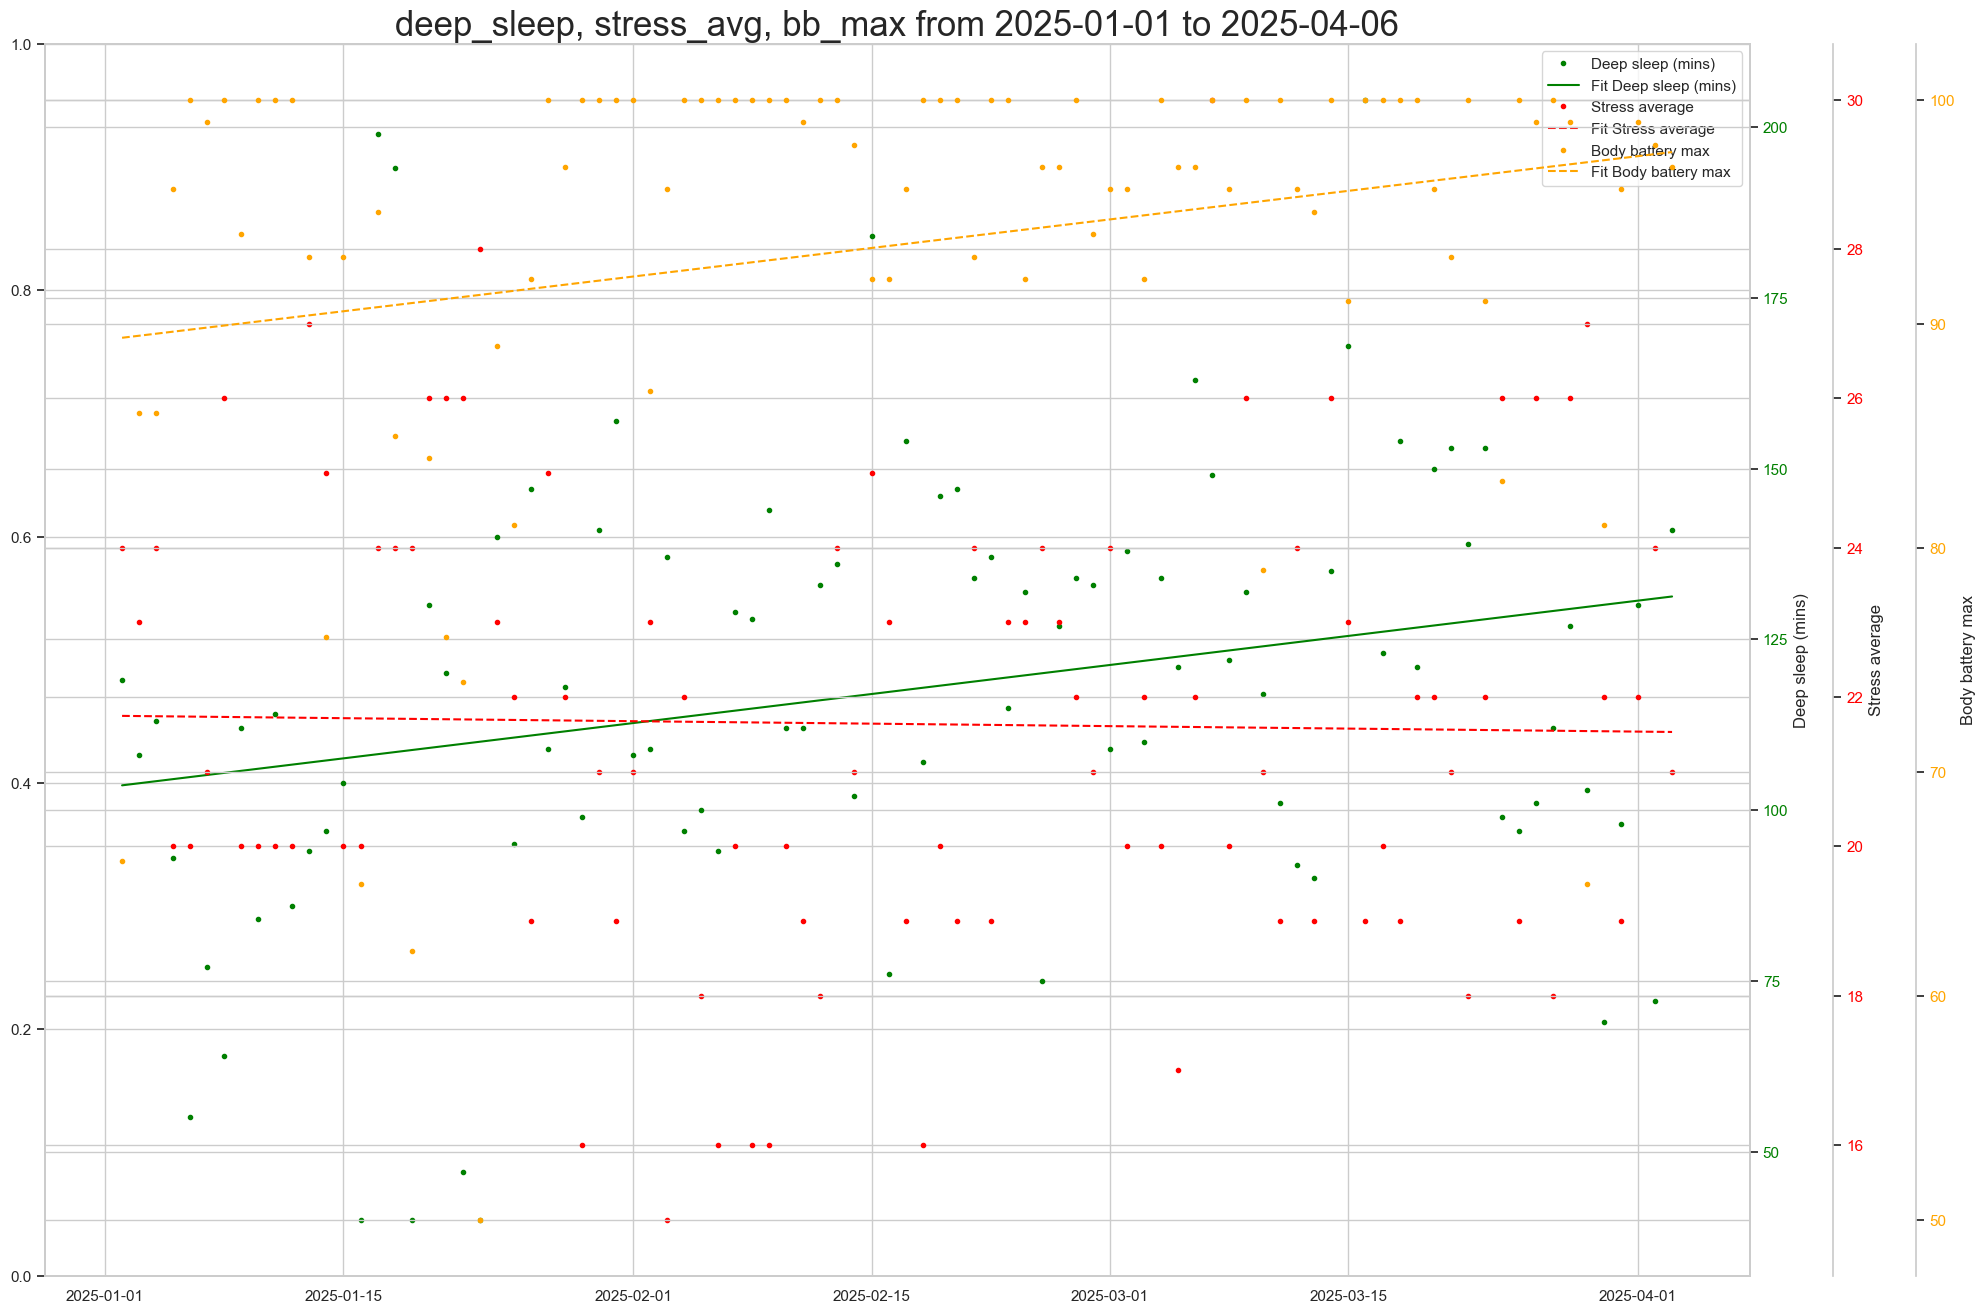

,,min,max
0,Fit Deep sleep (mins),103,131
1,Fit Stress average,21,21
2,Fit Body battery max,89,97


In [6]:


columns = { "stress_avg" : 
                   {
                       "label": "Stress average",
                       "trend_marker": "--",
                       "color": "red"

                   }, 
            "bb_max": 
                   {
                       "label": "Body battery max",
                       "trend_marker": "--",
                       "color": "orange"
                   },
           
            "sleep_avg": 
                   {
                       "label": "Sleep time (hrs)",
                       "trend_marker": "-.",
                       "color": "blue"
                  },
            "rem_sleep_max": 
                   {
                       "label": "Rem Sleep time (mins)",
                       "trend_marker": "-",
                       "color": "purple"
                   },
           
            "deep_sleep": 
                   {
                       "label": "Deep sleep (mins)",
                       "trend_marker": "-",
                       "color": "green"
                   }
          }

# these are the data columns to plot
show_cols = {"deep_sleep", "stress_avg", "bb_max"}

fig, host = plt.subplots(figsize=(22,16))

plots = []
fit_summary = []
step = 0

for col in show_cols:
    label=columns[col]["label"]
   
    ax2 = host.twinx()
    ax2.set_ylabel(label)
    ax2.tick_params(axis='y', labelcolor=columns[col]["color"])

    # data
    plot, = ax2.plot(dm_df.Date, dm_df[col], 'o', ms=3.0, color=columns[col]["color"], label=label)
    plots.append(plot)
    
    # trend
    fitlabel = 'Fit {}'.format(label)
    x_dates = dates.date2num(dm_df.Date)
    trend = np.polyfit(x_dates, dm_df[col].astype(float) , 1)
    fit = np.poly1d(trend)
    x_fit = np.linspace(x_dates.min(), x_dates.max())
    fit, = ax2.plot(dates.num2date(x_fit), fit(x_fit), linestyle=columns[col]["trend_marker"], color=columns[col]["color"],label=fitlabel)
    plots.append(fit)
    
    ax2.spines['right'].set_position(('outward', step))
    
    step = step + 60

    fit_data = fit.get_ydata()

    fit_summary.append({"": fitlabel, "min": math.floor(fit_data.min()), "max":math.floor(fit_data.max())})
    
host.legend(handles=plots, loc='best')

col_label = ""
for col in show_cols:
    if len(col_label):
        col_label += ", "
    col_label += f"{col}"

title = f"{col_label} from {start_ts.date()} to {end_ts.date()}"

plt.title(label=title, fontsize=25)

plt.show()
pd.DataFrame(fit_summary)

In [7]:
stress_df = pd.DataFrame([time, stress_avg]).T
stress_df.columns = ["Date", "stress_avg"]


df = pd.DataFrame({'date': time, 'value': stress_avg})

df['date'] = pd.to_datetime(df['date'])

# Extract day of the week and week number
df['day_of_week'] = df['date'].dt.day_name()
df['week'] = df['date'].dt.isocalendar().week

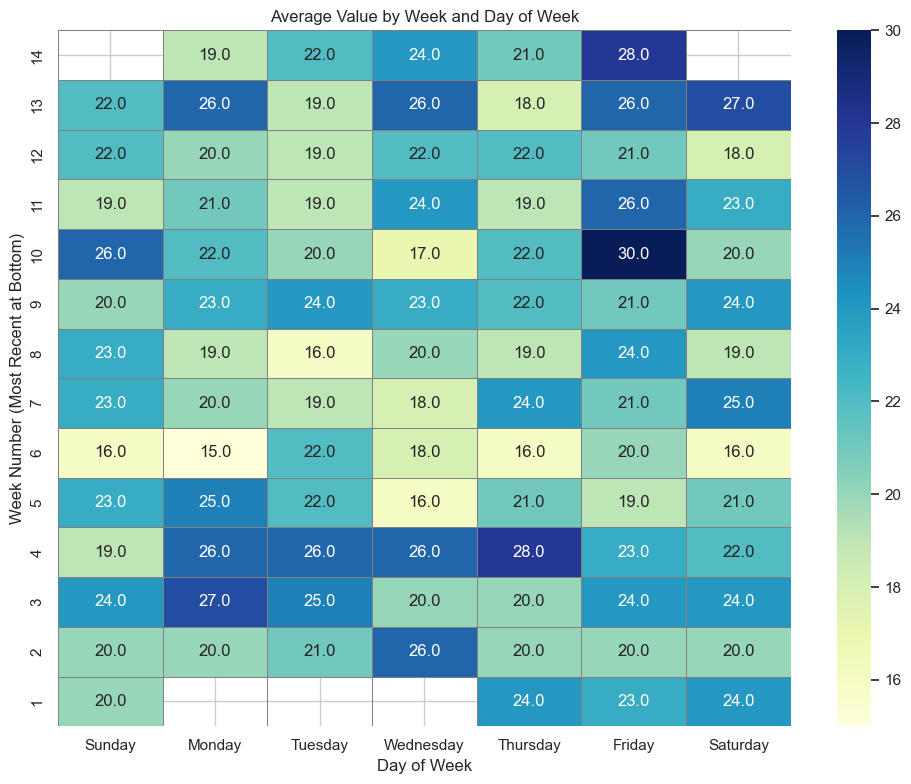

In [8]:

# Optional: ensure consistent order of days
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Pivot table: rows = week, columns = day of week
heatmap_data = df.pivot_table(index='week', columns='day_of_week', values='value', aggfunc='mean')
heatmap_data = heatmap_data[day_order]  # Order columns by day of week
heatmap_data = heatmap_data.sort_index(ascending=True)  # Ensure weeks are sorted

# Flip the week index so recent week is at the bottom
heatmap_data = heatmap_data.iloc[::-1]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='gray', annot=True, fmt=".1f")
plt.title('Average Value by Week and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Week Number (Most Recent at Bottom)')
plt.tight_layout()
plt.show()


In [9]:
average_by_day = df.groupby('day_of_week')['value'].mean().reindex(day_order)

# Display result
print(average_by_day)

day_of_week
Sunday       21.307692
Monday       21.769231
Tuesday      21.076923
Wednesday    21.538462
Thursday     21.142857
Friday       23.285714
Saturday     21.769231
Name: value, dtype: float64


In [10]:
# a = data[0]
# list(reversed(dir(a))) 

In [11]:

data_dict = [obj.__dict__ for obj in data]
df = pd.DataFrame(data_dict)


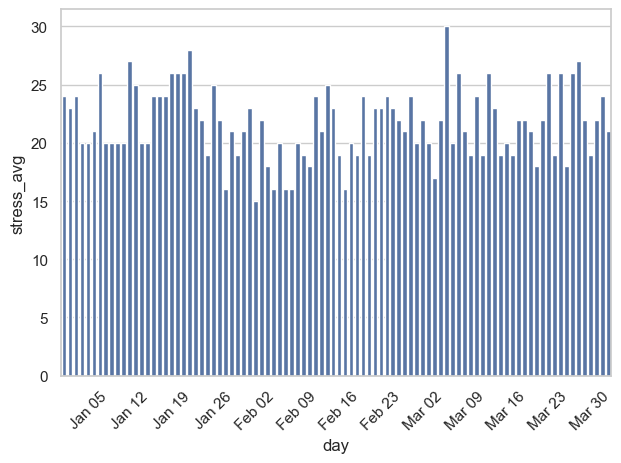

In [12]:

from datetime import date
import matplotlib.dates as mdates
# Define date range
start = date(2021, 1, 1)
end = date(2025, 4, 3)

filtered_df = df[(df['day'] >= start) & (df['day'] <= end)]

sns.barplot(x='day', y='stress_avg', data=filtered_df)

# Format x-axis
plt.xticks(rotation=45)  # slant labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # one tick per week (Mondays)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # e.g., "Apr 06"


plt.tight_layout()
plt.show()

93
                                  _sa_instance_state  rhr_max  \
0  <sqlalchemy.orm.state.InstanceState object at ...     58.0   
1  <sqlalchemy.orm.state.InstanceState object at ...     55.0   
2  <sqlalchemy.orm.state.InstanceState object at ...     55.0   
3  <sqlalchemy.orm.state.InstanceState object at ...     53.0   
4  <sqlalchemy.orm.state.InstanceState object at ...     51.0   

  moderate_activity_time sleep_min  calories_bmr_avg  hydration_avg  rr_min  \
0               00:22:00  07:08:54              2059            0.0     9.0   
1               00:10:00  08:34:22              2059            0.0     9.0   
2               01:08:00  08:53:00              2059            0.0     9.0   
3               00:08:00  08:18:00              2059            0.0    11.0   
4               00:57:00  08:10:44              2059            0.0     9.0   

   inactive_hr_avg vigorous_activity_time sleep_max  ...  weight_max  \
0        68.756757               00:02:00  07:08:54  ...   

<Axes: >

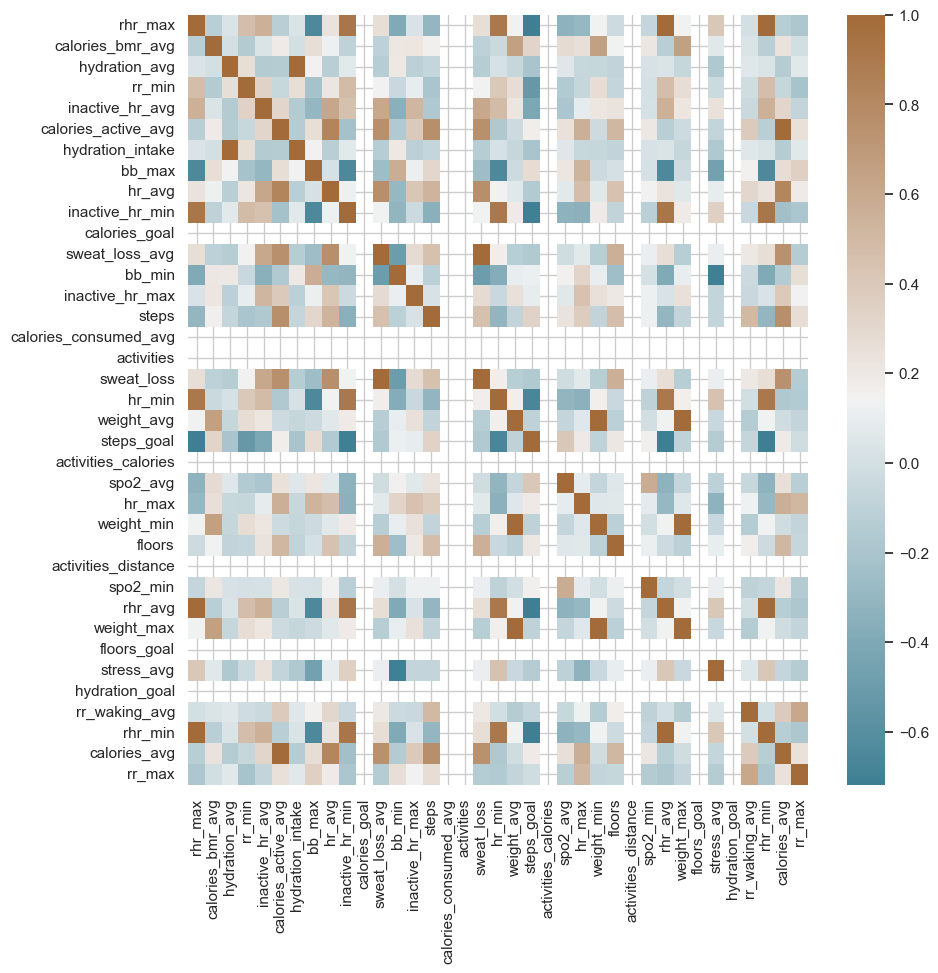

In [16]:
# df = df.drop("day_of_week", axis=1)

print(len(data_dict))

df = pd.DataFrame(data_dict)


df = df.drop('day', axis=1)
print(df.head())

cols_to_drop = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, datetime.time)).any()]
cols_to_drop.append("_sa_instance_state")
heatmap_df = df.drop(columns=cols_to_drop)

corr = heatmap_df.corr()# plot the heatmap

    
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, cmap=sns.diverging_palette(220, 40, as_cmap=True))

# df.corr(min_periods=3)